In [1]:
cd ../..

/home


In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os, sys
import h5py
import json

from sklearn.metrics import confusion_matrix
from core.plots import plot_cm
from core.phased import PhasedLSTM
from core.data import load_records
from core.losses import custom_bce
from core.metrics import custom_acc

%load_ext autoreload
%autoreload 2

In [5]:
exp_path = './runs/first_level/fold_1/'
data_path = './data/records/first_level/fold_0/'

In [6]:
def get_predictions(exp_path, data):
    lstm = tf.keras.models.load_model(
            os.path.join(exp_path, 'lstm', 'model.h5'),
            custom_objects={'PhasedLSTM': PhasedLSTM, 
                            'custom_bce':custom_bce,
                            'custom_acc':custom_acc}
        )

    phased = tf.keras.models.load_model(
            os.path.join(exp_path, 'phased', 'model.h5'),
            custom_objects={'PhasedLSTM': PhasedLSTM, 
                            'custom_bce':custom_bce,
                            'custom_acc':custom_acc}
        )
    
    y_pred_lstm   = lstm.predict(test_batches)
    y_pred_phased = phased.predict(test_batches)
    
    y_pred_lp = tf.divide(tf.add(y_pred_lstm[..., :-1], y_pred_phased[..., :-1]), 2)
    
    return {'lstm': y_pred_lstm[..., :-1], 'phased':y_pred_phased[..., :-1], 'lp':y_pred_lp}

In [7]:
metadata = pd.read_csv(os.path.join(data_path, 'test_samples.csv'))

In [19]:
cls_names = list(metadata['alerceclass'].unique())
num_classes = len(cls_names)
test_batches = load_records(os.path.join(data_path, 'test'),
                             256,
                             max_obs=200,
                             num_classes=num_classes,
                             mode=1,
                             shuffle=False)

In [20]:
lstm = tf.keras.models.load_model(
        os.path.join(exp_path, 'lstm', 'model.h5'),
        custom_objects={'PhasedLSTM': PhasedLSTM, 
                        'custom_bce':custom_bce,
                        'custom_acc':custom_acc}
    )

In [21]:
y_true = tf.concat([y for _, y in test_batches], 0)

In [22]:
y_pred = get_predictions('./runs/first_level/fold_0/', test_batches)

In [23]:
cm = confusion_matrix(np.argmax(y_true, 1), 
                      np.argmax(y_pred['lp'][:,-1,:], 1), normalize='true')

['Stochastic', 'Periodic', 'Transient']


<AxesSubplot:title={'center':'L+P'}>

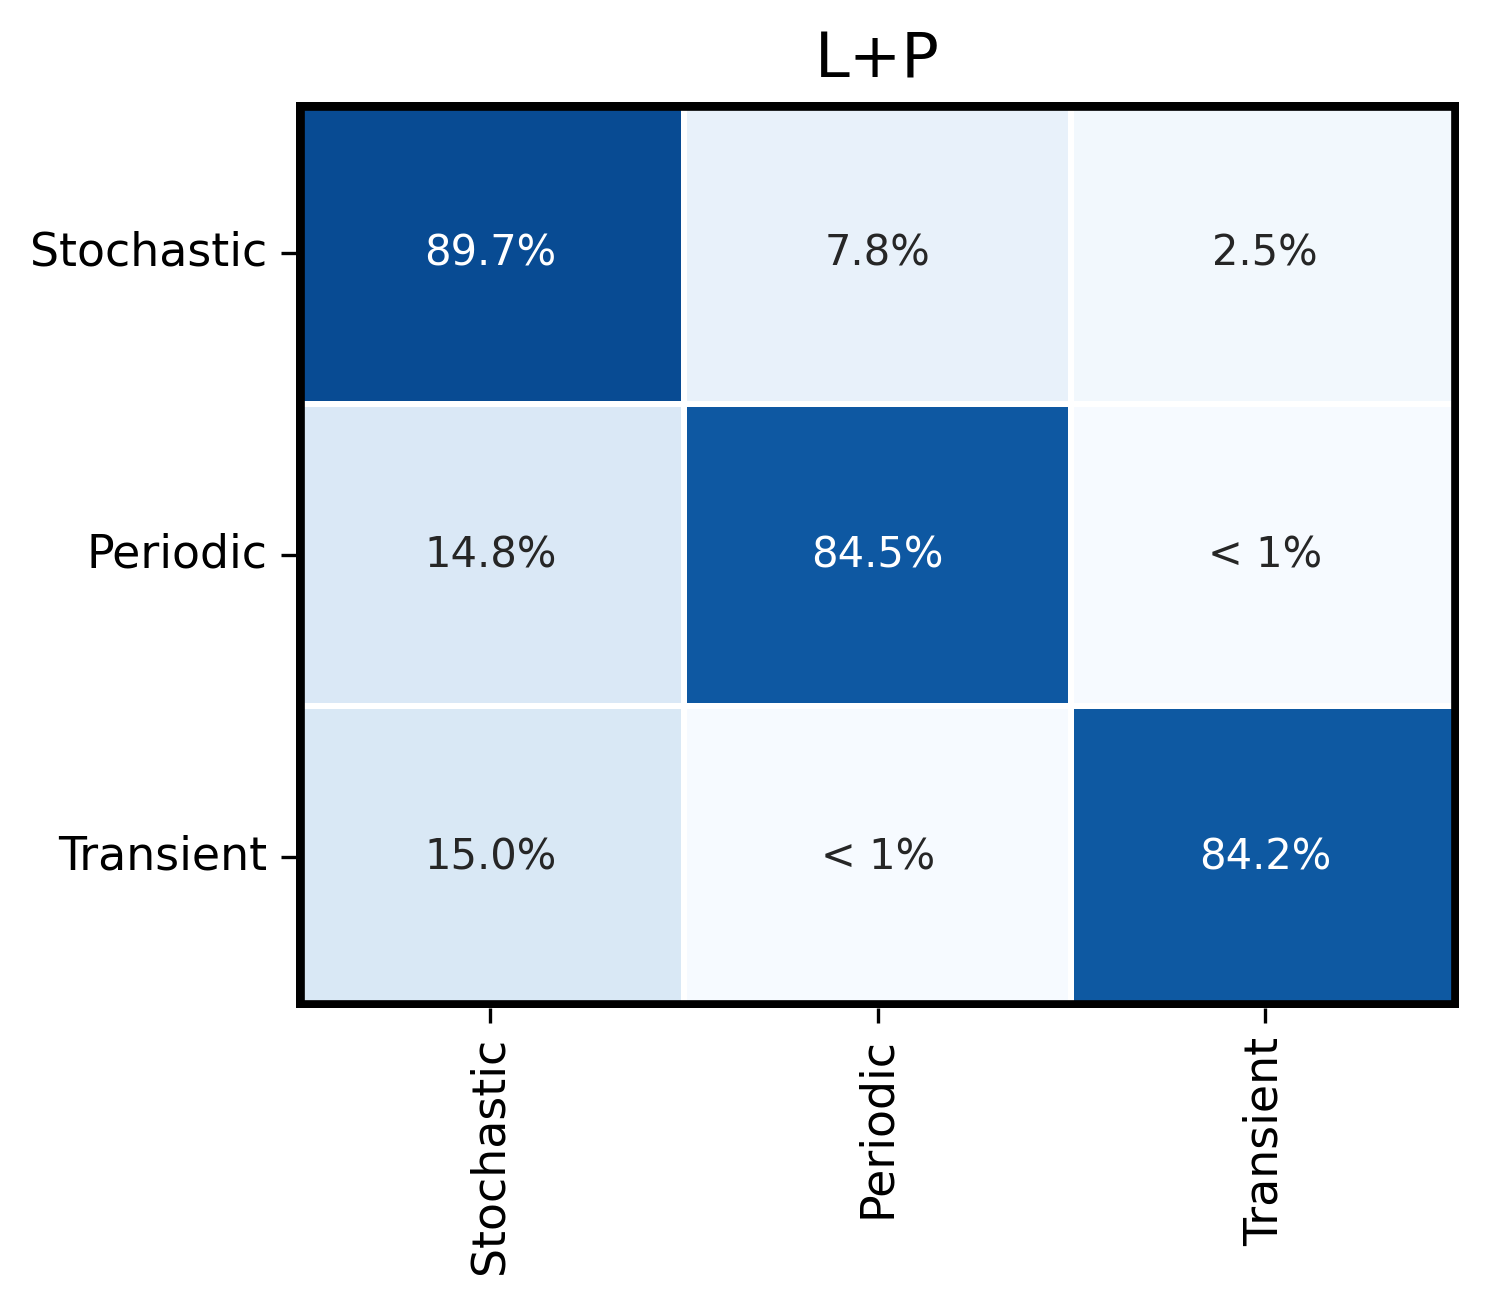

In [24]:
fig, axes = plt.subplots(1,1, figsize=(5,4), sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.01}, dpi=300)

# plot_cm(cm_0, axes[0], title=metrics_0['title'], class_names=cls_names_0, fontsize=10)
# plot_cm(cm_1, axes[1], title=metrics_1['title'], class_names=cls_names_0, fontsize=10)
plot_cm(cm, axes, title='L+P', class_names=cls_names, fontsize=10)

In [25]:
from sklearn.metrics import f1_score
from multiprocessing import cpu_count

In [26]:
def calculate_metrics(x, y):
    true = tf.argmax(y, 1)
    pred = tf.argmax(x, 1)
    f1 = f1_score(true, pred, average='macro')
    return f1

res = tf.map_fn(lambda x: calculate_metrics(x, y_true), 
                tf.transpose(y_pred['lp'], [1,0,2]))

Text(0.5, 0, 'Number of Observations')

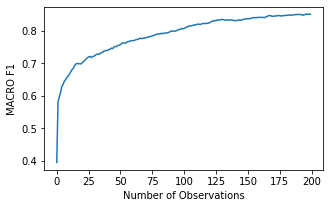

In [27]:
plt.figure(figsize=(5,3))
plt.plot(res)
plt.ylabel('MACRO F1')
plt.xlabel('Number of Observations')

In [31]:
from astropy.time import Time

In [33]:
batches = load_records(os.path.join(data_path, 'test'),
                       256,
                       max_obs=200,
                       num_classes=num_classes,
                       mode=1,
                       shuffle=False, 
                       normed=False)


times = tf.concat([x['input'][...,0] for x, _ in batches], 0)

In [ ]:
%%time
all_days_list = []
all_f1_list = []
for sample_time, predictions, labels in zip(times, y_pred['lp'], np.argmax(y_true, 1)):
    t = Time(sample_time, format='mjd')
    df = pd.DataFrame()
    df['mjd'] = times[0]
    df['iso'] = pd.to_datetime(t.isot)
    
    for k, name in enumerate(cls_names):
        df[name]= predictions[..., k]
    
    groups = df.groupby([df['iso'].dt.date])
    
    day_list = []
    f1_list  = []
    for d, g in groups:
        day_pred = np.argmax(g.iloc[:, 2:].values, 1)
        f1 = f1_score([labels]*len(day_pred), day_pred, average='macro')
        day_list.append(d)
        f1_list.append(f1)
    all_days_list.append(day_list)
    all_f1_list.append(f1_list)

/usr/local/lib/python3.8/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 171 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.8/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.8/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 72 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.8/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 57 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.8/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 6 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func

In [137]:
import numpy as np
import numpy.ma as ma
from itertools import zip_longest

mean_f1_by_day = np.nanmean(np.array(list(zip_longest(*all_f1_list)),dtype=float),axis=1)
std_f1_by_day = np.nanstd(np.array(list(zip_longest(*all_f1_list)),dtype=float),axis=1)

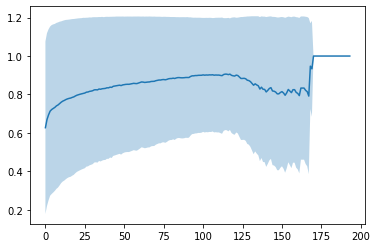

In [142]:
plt.plot(mean_f1_by_day)
plt.fill_between(range(len(mean_f1_by_day)), mean_f1_by_day-std_f1_by_day, mean_f1_by_day+std_f1_by_day,
                alpha=0.3)

In [143]:
all_f1_list[-1]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]